In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Ignore Warning mwssages
import warnings
warnings.filterwarnings("ignore")

#### Define Transforms

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # reverse 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

## Prepare train and test sets, loaders
We're going to take advantage of a built-in torchvision dataset tool called  <tt>Imagefolder</tt>

In [3]:
root = "../../../CATS_DOGS"

train_data = datasets.ImageFolder(os.path.join(root, "train"), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, "test"), transform=test_transform)
print(train_data)
print(test_data)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes
print(f"class names : {class_names}")
print(f"Training images available : {len(train_data)}")
print(f"Testing images available : {len(test_data)}")

Dataset ImageFolder
    Number of datapoints: 18743
    Root location: ../../../CATS_DOGS/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 6251
    Root location: ../../../CATS_DOGS/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
class names : ['CAT', 'DOG']
Training images available : 18743
Testing images available

## Display a batch of images
To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

In [4]:
for images, labels in train_loader:
    break

In [5]:
images.shape

torch.Size([10, 3, 224, 224])

In [6]:
images[0][0]

tensor([[-1.8953, -1.8782, -1.8953,  ..., -2.1179, -2.1179, -2.1179],
        [-1.8953, -1.8782, -1.8953,  ..., -2.1179, -2.1179, -2.1179],
        [-1.8953, -1.8782, -1.9124,  ..., -2.1179, -2.1179, -2.1179],
        ...,
        [-2.1179, -2.1179, -2.1179,  ..., -1.7925, -1.7754, -1.7925],
        [-2.1179, -2.1179, -2.1179,  ..., -1.7925, -1.7925, -1.8097],
        [-2.1179, -2.1179, -2.1179,  ..., -1.8097, -1.8097, -1.8268]])

In [7]:
print(f"Labels : {labels.numpy()}")
print(f"Classes : ", *np.array([class_names[i] for i in labels]))

Labels : [1 1 0 0 1 1 0 1 0 0]
Classes :  DOG DOG CAT CAT DOG DOG CAT DOG CAT CAT


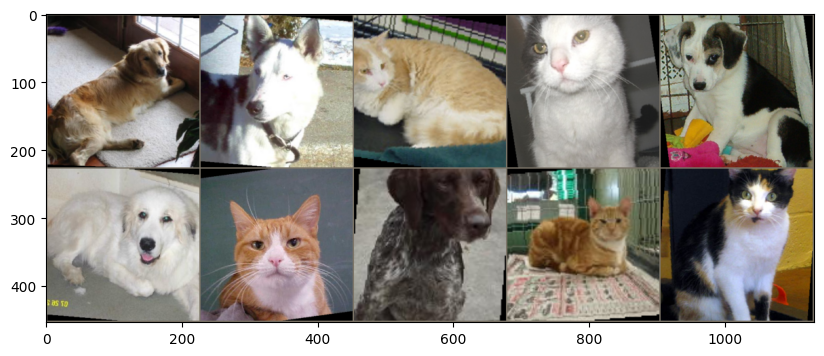

In [8]:
im = make_grid(images, nrow=5) # the default nrow is 8

# Inverse normalize the images
inv_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
    )
im_inv = inv_transform(im) 

plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [9]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
        self.con2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.con2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)



In [10]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (con2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [11]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f"{item:>8}")
    print(f"_____\n{sum(params)}")

count_parameters(model=CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
_____
5610222


#### Train the model
In the interests of time, we'll limit the number of training batches to 800, and the number of testing batches to 300. We'll train the model on 8000 of 18743 available images, and test it on 3000 out of 6251 images.

In [12]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 1000
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):

        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        #Apply the model
        y_pred = CNNmodel(X_train)
        #Calculate the loss
        loss = criterion(y_pred,y_train)

        #Tally the number of correct matches
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Clear the previously accumulated gradients
        optimizer.zero_grad()
        # Backward pass compute gradient of the loss w.r.t model parameters
        loss.backward()
        # Step optimizer to update model parameters based on the current gradient
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/10000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    train_correct.append(trn_corr)
    train_losses.append(loss)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            #Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/10000]  loss: 0.63115966  accuracy:  55.500%
epoch:  0  batch:  400 [  4000/10000]  loss: 0.55435354  accuracy:  57.500%
epoch:  0  batch:  600 [  6000/10000]  loss: 0.67009407  accuracy:  60.167%
epoch:  0  batch:  800 [  8000/10000]  loss: 0.52413732  accuracy:  61.712%
epoch:  0  batch: 1000 [ 10000/10000]  loss: 0.74241048  accuracy:  63.310%
epoch:  1  batch:  200 [  2000/10000]  loss: 0.58210599  accuracy:  70.450%
epoch:  1  batch:  400 [  4000/10000]  loss: 0.53337240  accuracy:  70.700%
epoch:  1  batch:  600 [  6000/10000]  loss: 0.29026467  accuracy:  71.733%
epoch:  1  batch:  800 [  8000/10000]  loss: 0.60811406  accuracy:  72.763%
epoch:  1  batch: 1000 [ 10000/10000]  loss: 0.35432491  accuracy:  73.310%
epoch:  2  batch:  200 [  2000/10000]  loss: 0.42849684  accuracy:  75.850%
epoch:  2  batch:  400 [  4000/10000]  loss: 0.58375782  accuracy:  76.125%
epoch:  2  batch:  600 [  6000/10000]  loss: 0.42491847  accuracy:  76.267%
epoch:  2  b

## Save the trained model

In [13]:
torch.save(CNNmodel.state_dict(), "CustomImageCNNModel.pt")

## Evaluate model performance

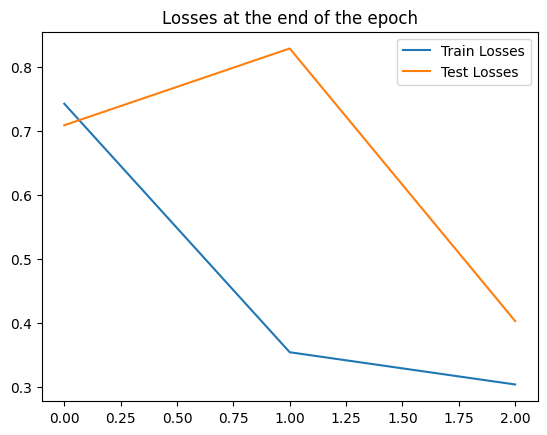

In [14]:
tmp_train_losses = [loss.detach().numpy() for loss in train_losses]
tmp_test_losses = [loss.detach().numpy() for loss in test_losses]
plt.plot(tmp_train_losses, label="Train Losses")
plt.plot(tmp_test_losses, label="Test Losses")
plt.title("Losses at the end of the epoch")
plt.legend()

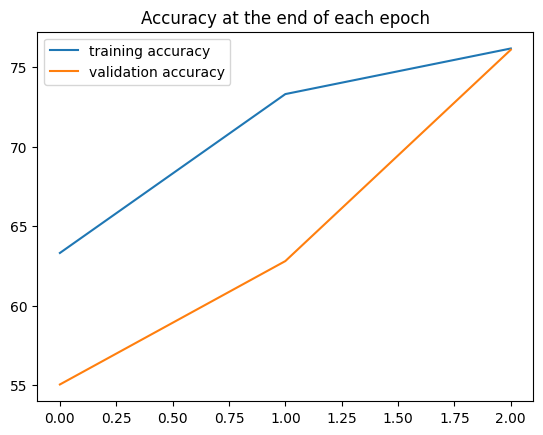

In [15]:
plt.plot([t/100 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [16]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(1651), tensor(1884), tensor(2283)]
Test accuracy: 76.100%


## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use AlexNet:

In [22]:
AlexNetModel = models.alexnet(pretrained=True)
AlexNetModel

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/sampanig/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 34.7MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

This model uses <a href='https://pytorch.org/docs/master/nn.html#torch.nn.AdaptiveAvgPool2d'><tt><strong>torch.nn.AdaptiveAvgPool2d(<em>output_size</em>)</strong></tt></a> to convert the large matrix coming out of the convolutional layers to a (6x6)x256 matrix being fed into the fully connected layers.

## Freeze feature parameters
We want to freeze the pre-trained weights & biases. We set <tt>.requires_grad</tt> to False so we don't backprop through them.

In [26]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

## Modify the classifier
Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier" in the AlexNet model.<br>
Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [43]:
torch.manual_seed(42)
AlexNetModel.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(in_features=1024, out_features=2),#In the Linear layer the bias is bydefault True so no need to mention that
    nn.LogSoftmax(dim=1)
    )
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [44]:
count_parameters(AlexNetModel)

 9437184
    1024
    2048
       2
_____
9440258


## Define loss function & optimizer
We only want to optimize the classifier parameters, as the feature parameters are frozen.

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(), lr=0.001)

## Train the model
Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we only need to run one epoch.

In [46]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 1000
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        #Apply the model
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)

        #Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Clear the previously accumulated gradients
        optimizer.zero_grad()
        # Backward pass compute gradient of the loss w.r.t model parameters
        loss.backward()
        # Step optimizer to update model parameters based on the current gradient
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/1000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                    break

            # Apply the model
            y_val = AlexNetModel(X_test)
            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted==y_test).sum()
        
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)


print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
        


epoch:  0  batch:  200 [  2000/1000]  loss: 1.85940576  accuracy:  89.550%
epoch:  0  batch:  400 [  4000/1000]  loss: 0.24472609  accuracy:  90.700%
epoch:  0  batch:  600 [  6000/1000]  loss: 0.35031977  accuracy:  91.567%
epoch:  0  batch:  800 [  8000/1000]  loss: 0.02226425  accuracy:  92.375%
epoch:  0  batch: 1000 [ 10000/1000]  loss: 0.07483693  accuracy:  92.690%

Duration: 102 seconds


In [51]:
print(test_correct)
print(f"Test accuracy : {(test_correct[-1]/3000)*100:.3f}%")

[tensor(2847)]
Test accuracy : 94.900%


## Run a new image through the model
We can also pass a single image through the model to obtain a prediction.<br>
Pick a number from 0 to 6250, assign it to "x", and we'll use that value to select an image from the Cats and Dogs test set.

torch.Size([3, 224, 224])


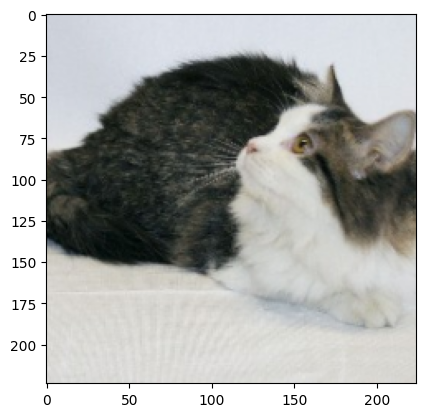

In [58]:
x = 2019
im = inv_transform(test_data[x][0])
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1,2,0)))


In [65]:
# CNN model prediciton
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224))
    pred_value = new_pred.argmax()
print(f"Predicted Value : {pred_value.item()} {class_names[pred_value.item()]}")

Predicted Value : 0 CAT


In [67]:
#tensor([[-0.6092, -0.7848]])
with torch.no_grad():
    new_pred = AlexNetModel(test_data[x][0].view(1,3,224,224))
    pred_value = new_pred.argmax()
print(f"Predicted Value : {pred_value.item()} {class_names[pred_value.item()]}")

Predicted Value : 0 CAT
